In [ ]:
%matplotlib notebook
from time import time
from torch.autograd import Variable

from FrEIA.framework import *
from FrEIA.modules import *

import config as c

import losses
import model
import monitoring
import torch
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def noise_batch(ndim):
    return torch.randn(c.batch_size, ndim).to(c.device)

def loss_max_likelihood(out, y):
    jac = model.model.jacobian(run_forward=False)

    neg_log_likeli = ( 0.5 / c.y_uncertainty_sigma**2 * torch.sum((out[:, -ndim_y:]       - y[:, -ndim_y:])**2, 1)
                     + 0.5 / c.zeros_noise_scale**2   * torch.sum((out[:, ndim_z:-ndim_y] - y[:, ndim_z:-ndim_y])**2, 1)
                     + 0.5 * torch.sum(out[:, :ndim_z]**2, 1)
                     - jac)

    return c.lambd_max_likelihood * torch.mean(neg_log_likeli)

def loss_forward_mmd(out, y):
    # Shorten output, and remove gradients wrt y, for latent loss
    output_block_grad = torch.cat((out[:, :c.ndim_z],
                                   out[:, -c.ndim_y:].data), dim=1)
    y_short = torch.cat((y[:, :c.ndim_z], y[:, -c.ndim_y:]), dim=1)

    l_forw_fit = c.lambd_fit_forw * losses.l2_fit(out[:, c.ndim_z:], y[:, c.ndim_z:])
    l_forw_mmd = c.lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))

    return l_forw_fit, l_forw_mmd

def loss_backward_mmd(x, y):
    x_samples = model.model(y, rev=True)
    MMD = losses.backward_mmd(x, x_samples)
    if c.mmd_back_weighted:
        MMD *= torch.exp(- 0.5 / c.y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
    return c.lambd_mmd_back * torch.mean(MMD)

def loss_reconstruction(out_y, y, x):
    cat_inputs = [out_y[:, :c.ndim_z] + c.add_z_noise * noise_batch(c.ndim_z)]
    if c.ndim_pad_zy:
        cat_inputs.append(out_y[:, c.ndim_z:-c.ndim_y] + c.add_pad_noise * noise_batch(c.ndim_pad_zy))
    cat_inputs.append(out_y[:, -c.ndim_y:] + c.add_y_noise * noise_batch(c.ndim_y))

    x_reconstructed = model.model(torch.cat(cat_inputs, 1), rev=True)
    return c.lambd_reconstruct * losses.l2_fit(x_reconstructed, x)

torch.Size([10000, 3, 244, 256])
Node 'conv_high_res_0' takes the following inputs:
	 Output #0 of node 'input' with dims (3, 244, 256)

Node 'permute_high_res_0' takes the following inputs:
	 Output #0 of node 'conv_high_res_0' with dims (3, 244, 256)

Node 'conv_high_res_1' takes the following inputs:
	 Output #0 of node 'permute_high_res_0' with dims (3, 244, 256)

Node 'permute_high_res_1' takes the following inputs:
	 Output #0 of node 'conv_high_res_1' with dims (3, 244, 256)

Node 'conv_high_res_2' takes the following inputs:
	 Output #0 of node 'permute_high_res_1' with dims (3, 244, 256)

Node 'permute_high_res_2' takes the following inputs:
	 Output #0 of node 'conv_high_res_2' with dims (3, 244, 256)

Node 'conv_high_res_3' takes the following inputs:
	 Output #0 of node 'permute_high_res_2' with dims (3, 244, 256)

Node 'permute_high_res_3' takes the following inputs:
	 Output #0 of node 'conv_high_res_3' with dims (3, 244, 256)

Node '5981c8' takes the following inputs:
	 

In [ ]:
model.load("checkpoints/my_inn.ckpt")

In [3]:
model.model.eval()
loader = c.train_loader
nograd = torch.no_grad()
nograd.__enter__()

In [4]:
for x, y in loader:
    break

In [12]:
x, y = Variable(x).to(c.device), Variable(y).to(c.device)
if c.add_y_noise > 0:
        y += c.add_y_noise * noise_batch(c.ndim_y)
if c.ndim_pad_x:
    x = torch.cat((x, c.add_pad_noise * noise_batch(c.ndim_pad_x)), dim=1)
if c.ndim_pad_zy:
    y = torch.cat((c.add_pad_noise * noise_batch(c.ndim_pad_zy), y), dim=1)
y = torch.cat((noise_batch(c.ndim_z), y), dim=1)

out_x = model.model(y, rev=True)

<IPython.core.display.Javascript object>


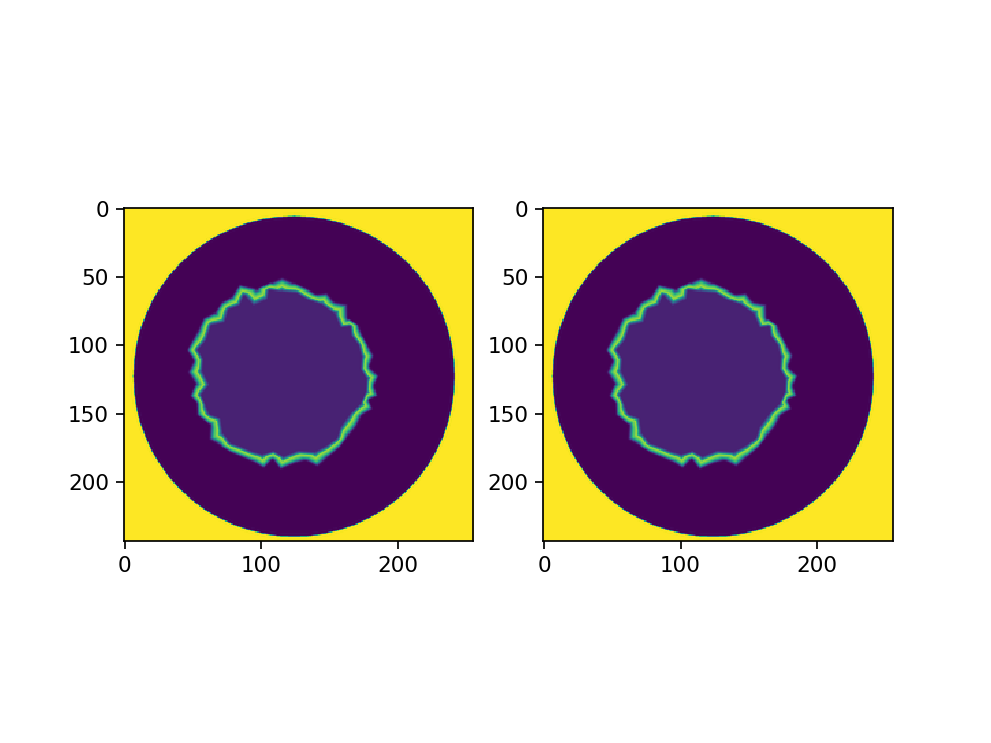

In [20]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(out_x[0,0,:,:].cpu().numpy())
ax[1].imshow(x[0,0,:,:].cpu().numpy())

In [23]:
output_block_grad = torch.cat((out_y[:, :c.ndim_z],
                               out_y[:, -c.ndim_y:].data), dim=1)
y_short = torch.cat((y[:, :c.ndim_z], y[:, -c.ndim_y:]), dim=1)

l_forw_mmd = c.lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))